<a href="https://colab.research.google.com/github/LuFernandez/neural-networks/blob/master/naive_bayes_gaussiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Gaussiano
###Lucero Guadalupe Fernandez 2020

## Dataset: Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) es un dataset con imágenes de prendas de vestir (artículos de la compañía Zalando). Son 70000 imágenes en baja resolución (28x28 pixeles), en escala de grises, agrupadas en 10 clases. Se utiliza en la comunidad de Machine Learning para comparación de algoritmos, de la misma forma que el dataset MNIST.

In [0]:
from sklearn.datasets import fetch_openml 
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)

El objetivo de esta práctica es utilizar la técnica de Naive Bayes gaussiano como clasificador de imágenes, siguiendo la notebook para obtener las respuestas del cuestionario en Campus

## Exploratory Data Analysis (EDA)

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [0]:
label_dict = {
                '0':'T-shirt/top',
                '1':'Trouser',
                '2':'Pullover',
                '3':'Dress',
                '4':'Coat',
                '5':'Sandal',
                '6':'Shirt',
                '7':'Sneaker',
                '8':'Bag',
                '9':'Ankle boot'
            }

**Distribución de clases**

- ¿El dataset está balanceado? 

In [6]:
pd.Series([label_dict[label] for label in y]).value_counts()

Bag            7000
Sneaker        7000
Dress          7000
Coat           7000
Pullover       7000
Trouser        7000
Ankle boot     7000
Sandal         7000
T-shirt/top    7000
Shirt          7000
dtype: int64

**Sí**

- Redimensionar los datos de entrada con la dimensión de las imágenes

In [0]:
X = X.reshape(len(X),28,28)

**Plots**

- Graficar las primeras 150 imágenes como una grilla

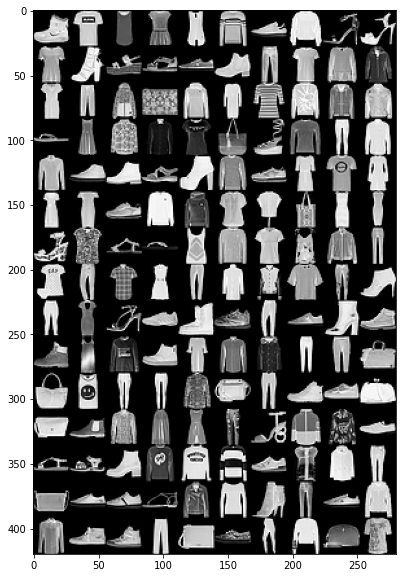

In [8]:
#https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy

def gallery(array, ncols=10, nrows=15):
    nindex, height, width = array.shape
    array = array[:(ncols*nrows)]
    #nrows = nindex//ncols
    #assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result


result = gallery(X[:150])
plt.figure(figsize=(50,10))
plt.imshow(result, cmap='gray')
plt.show()

- Graficar las primeras 100 imágenes de cada clase

100 primeras imágenes de la clase: 9


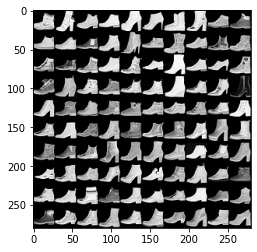

100 primeras imágenes de la clase: 0


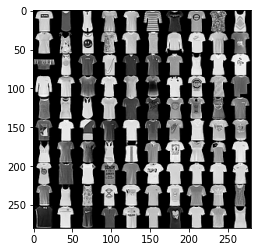

100 primeras imágenes de la clase: 3


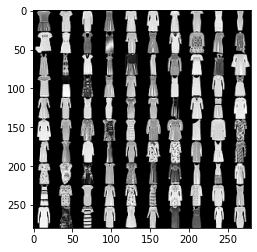

100 primeras imágenes de la clase: 2


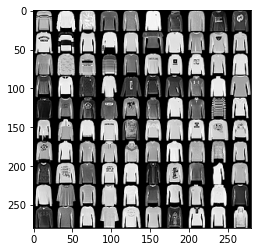

100 primeras imágenes de la clase: 7


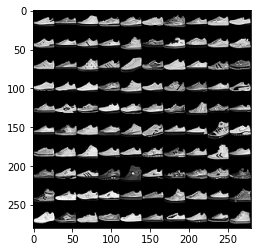

100 primeras imágenes de la clase: 5


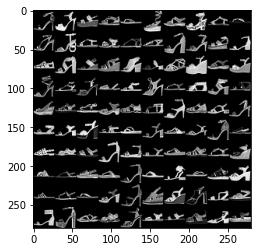

100 primeras imágenes de la clase: 1


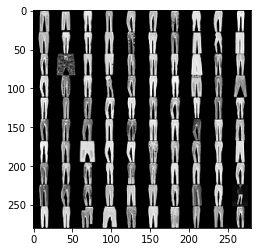

100 primeras imágenes de la clase: 6


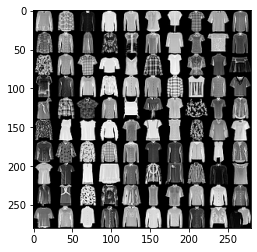

100 primeras imágenes de la clase: 4


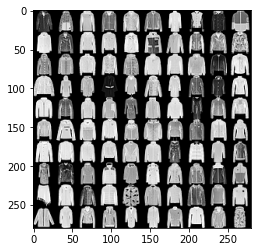

100 primeras imágenes de la clase: 8


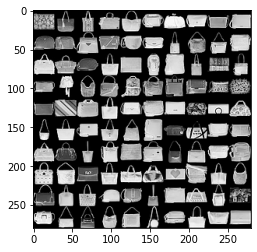

In [9]:
imgs_by_class = dict()
for i in range(len(X[:2000])):
  if y[i] in imgs_by_class:
    imgs_by_class[y[i]] = np.concatenate((imgs_by_class[y[i]], np.array([X[i]])))
  else:
    imgs_by_class[y[i]] = np.array([X[i]])

for index in imgs_by_class:
  print("100 primeras imágenes de la clase:", index)
  imgs_by_class[index] = imgs_by_class[index].reshape(-1, 28, 28)
  result = gallery(imgs_by_class[index], 10, 10)
  plt.imshow(result, cmap='gray')
  plt.show()

**Split train-validation**

- Dividir los datos en train, validation y test, en un ratio 5:1:1, usando **random_state=42**. De forma estratificada por clases

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_testprima, y_train, y_testprima = train_test_split(X, y, test_size=2/7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_testprima, y_testprima, test_size=0.5, random_state=42)

Chequear que quedaron balanceados:


In [11]:
print('TRAIN')
print(pd.Series([label_dict[label] for label in y_train]).value_counts(normalize=True))

print('VALIDATION')
print(pd.Series([label_dict[label] for label in y_val]).value_counts(normalize=True))

print('TEST')
print(pd.Series([label_dict[label] for label in y_test]).value_counts(normalize=True))

TRAIN
Bag            0.1
Sneaker        0.1
Dress          0.1
Coat           0.1
Pullover       0.1
Trouser        0.1
Ankle boot     0.1
Sandal         0.1
T-shirt/top    0.1
Shirt          0.1
dtype: float64
VALIDATION
T-shirt/top    0.1051
Sandal         0.1014
Trouser        0.1009
Sneaker        0.1009
Shirt          0.1004
Bag            0.1003
Coat           0.0996
Pullover       0.0985
Ankle boot     0.0967
Dress          0.0962
dtype: float64
TEST
Dress          0.1038
Ankle boot     0.1033
Pullover       0.1015
Coat           0.1004
Bag            0.0997
Shirt          0.0996
Trouser        0.0991
Sneaker        0.0991
Sandal         0.0986
T-shirt/top    0.0949
dtype: float64


## Naive Bayes Gaussiano

**Análisis pixel por pixel**

Se puede modelar cada pixel como una variable aleatoria continua, cuyo dominio está entre 0 y 255. En ese caso, cada observación tendrá un conjunto de features: 

$X = [ X_{(0,0)},X_{(0,1)},...,X_{(0,27)},X_{(1,0)},...,X_{(27,27)} ]$

donde $X_{(i,j)}$ es la variable aleatoria del valor de gris del pixel de coordenadas i,j


- *¿Cuántas variables aleatorias se samplean para generar una imagen?* 

In [12]:
print(28*28)

784


**Teorema de Bayes**

Para aplicar el Teorema de Bayes es necesario conocer el **likelihood** de cada $X$ dada la clase $y$, es decir $P(X|Y)$

Por ejemplo, si se representa una imagen negra como un vector $v=[0,...,0]$ de 784 ceros. Entonces $P(X=v|Y=1)$ es el likelihood de que una imagen de clase 'Trouser' sea una imagen negra. 

Por otro lado, la probabilidad a posteriori $P(Y=1|X=v)$ es la probabilidad de que una imagen negra pertenezca a la clase 'Trouser'


¿Cómo se puede estimar $P(X|Y)$ para cada clase y para cada posible combinación de píxeles? Si se asume que hay independencia entre las variables aleatorias, se puede calcular el likelihood de $X$ como el producto de los likelihoods $X_{i,j}$ individuales: 

$P(X|Y) = P(X_{(0,0)}|Y) P(X_{(0,1)}|Y) ... P(X_{(27,27)}|Y) \rightarrow$   *Naive Bayes*  

**Distribución gaussiana**

Como se vio en la práctica anterior, el clasificador de Naive Bayes resulta útil para el caso de datos discretos, como el caso de la moneda o el clasificador de artículos. Para utilizarlo con datos continuos habría que hacer una binarización de los datos y eso usualmente aumenta mucho la cantidad de parámetros. 

Otra opción es asumir que los valores tienen una distribución gaussiana, en cuyo caso se separan los datos en las $K$ clases que se quieren diferenciar y se obtienen las medias y varianzas de cada clase. 

Si se tiene una observación $v$ que se quiere clasificar, se procede a calcular con cual de las $k$ distribuciones es más probable que la observación haya sido generada.

$p(x=v|Y_k) = \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(v-\mu_k)²}{2\sigma_k^2}} \rightarrow $ *Distribución gaussiana*

Dado que cada pixel es una variable aleatoria continua, se puede modelar como una distribución normal. 

- ¿Cuál es la media y el desvío estándar del pixel (10,10) en la clase 'Trouser' estimados a partir del set de train?

In [0]:
import math
inv_label = {v: k for k, v in label_dict.items()}

In [14]:
trouser_10_10 = X_train[y_train==inv_label['Trouser'], 10, 10]
mean_t = np.mean(trouser_10_10)
sigma_t = np.std(trouser_10_10)
print("media", mean_t)
print("desviacion", sigma_t)

media 183.6356
desviacion 58.28268707463649


- Graficar la distribución normal del pixel (10,10) de la clase 'Trouser' y de la clase 'Pullover'

In [0]:
pull_10_10 = X_train[y_train==inv_label['Pullover'], 10, 10]
mean_p = np.mean(pull_10_10)
sigma_p = np.std(pull_10_10)

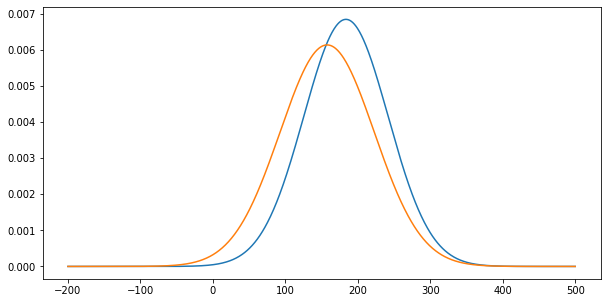

In [16]:
import scipy.stats as stats
import math

x = np.linspace(-200, 500, 1000)
gauss_t = stats.norm(mean_t, sigma_t)
gauss_p = stats.norm(mean_p, sigma_p)

plt.figure(figsize=(10, 5))
plt.plot(x, gauss_t.pdf(x))
plt.plot(x, gauss_p.pdf(x))
plt.show()

- *¿Cuál es la media y el desvío estándar del pixel (14,14) en la clase 'Bag' estimados a partir del set de train?*

In [17]:
bag_14_14 = X_train[y_train==inv_label['Bag'], 14, 14]
mean_b = np.mean(bag_14_14)
sigma_b = np.std(bag_14_14)
print("media", mean_b)
print("desviacion", sigma_b)

media 159.4184
desviacion 63.17199808016207


- Armar una matriz con la media y el desvío para cada pixel y para cada clase. Tendrá dimensión (2x784x10)
- Escribir una función para el plot de una gaussiana
- Graficar las distribuciones del pixel (10,10) para las 10 clases. 

In [0]:
def plot_gaussian(mu=100, sigma=50):
  x = np.linspace(-200, 500, 1000)
  gauss = stats.norm(mu, sigma)
  plt.plot(x, gauss.pdf(x))
  return None

matriz = np.zeros((2, 784, 10))

for label in label_dict:
  for j in range(28):
    for i in range(28):
      pixel_i_j = X_train[y_train==label, i, j]
      matriz[0][j*28+i][int(label)] = np.mean(pixel_i_j)
      matriz[1][j*28+i][int(label)] = np.std(pixel_i_j)

Pixel (10,10) para la categoría 0: mu=152.3288, sigma=63.234666841535585
Pixel (10,10) para la categoría 1: mu=183.6356, sigma=58.28268707463649
Pixel (10,10) para la categoría 2: mu=157.678, sigma=65.0103985220826
Pixel (10,10) para la categoría 3: mu=134.1858, sigma=82.99306524258517
Pixel (10,10) para la categoría 4: mu=172.7268, sigma=55.90403350170719
Pixel (10,10) para la categoría 5: mu=11.5978, sigma=37.0520017699449
Pixel (10,10) para la categoría 6: mu=141.438, sigma=65.6321487991975
Pixel (10,10) para la categoría 7: mu=6.2412, sigma=26.248714683961197
Pixel (10,10) para la categoría 8: mu=142.9552, sigma=74.38841571750268
Pixel (10,10) para la categoría 9: mu=3.3686, sigma=21.686639528520782


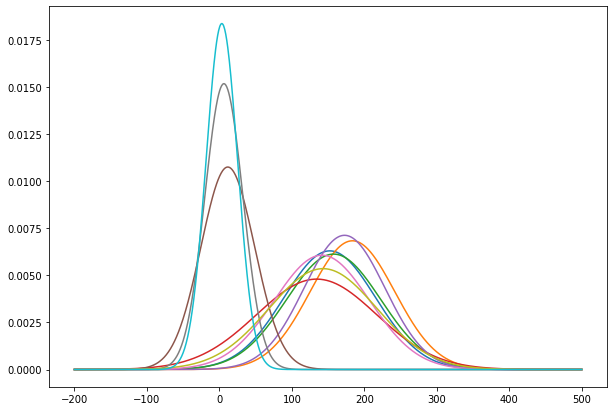

In [20]:
plt.figure(figsize=(10,7))
for i in range(10):
  mu = matriz[0][10*28+10][i]
  sig = matriz[1][10*28+10][i]
  plot_gaussian(mu, sig)
  print(f"Pixel (10,10) para la categoría {i}: mu={mu}, sigma={sig}")
  

plt.show()

**Priori, likelihood y posteriori**
- *¿Cuál es el likelihood de observar en las imágenes de 'Trouser' un valor de gris 145 en el pixel (10,10)? Estimado con el set de train*
- Calcule las probabilidades a priori de las 10 clases
- *Con los dos resultados anteriores, calcule la probabilidad a posteriori no normalizada de que un valor de 145 observado en el pixel (10,10) pertenezca a una imagen de Trouser*
- *Según el criterio de maximum likelihood, ¿qué clase es más probable que haya generado una imagen con un valor de gris 145 en el pixel (10,10)?*

In [33]:
print("¿Cuál es el likelihood de observar en las imágenes de 'Trouser' un valor de gris 145 en el pixel (10,10)? Estimado con el set de train")
likelihood = stats.norm.pdf(145, mean_t, sigma_t)
print(likelihood)

print("Calcule las probabilidades a priori de las 10 clases")
priori = 0.1
print("Al estar balanceado, las prob a priori para cada clase serán iguales a 1/10=0.1")

print("calcule la probabilidad a posteriori no normalizada de que un valor de 145 observado en el pixel (10,10) pertenezca a una imagen de Trouser")
print("prob a priori", priori*likelihood)

value = np.zeros(10)
for i in range(10):
  mu = matriz[0][10*28+10][i]
  sig = matriz[1][10*28+10][i]
  value[i] = stats.norm.pdf(145, mu, sig)
  print(f"category {i}, with prob= {value[i]*0.1}")

print(f"clase es más probable que haya generado una imagen con un valor de gris 145 en el pixel (10,10): categoría 4 con prob = {value[4]}")

¿Cuál es el likelihood de observar en las imágenes de 'Trouser' un valor de gris 145 en el pixel (10,10)? Estimado con el set de train
0.005494751575165973
Calcule las probabilidades a priori de las 10 clases
Al estar balanceado, las prob a priori para cada clase serán iguales a 1/10=0.1
calcule la probabilidad a posteriori no normalizada de que un valor de 145 observado en el pixel (10,10) pertenezca a una imagen de Trouser
prob a priori 0.0005494751575165973
category 0, with prob= 0.0006266687110321171
category 1, with prob= 0.0005494751575165973
category 2, with prob= 0.000602100443399754
category 3, with prob= 0.00047663000264438235
category 4, with prob= 0.0006310320157452473
category 5, with prob= 1.6490637105158408e-06
category 6, with prob= 0.0006069512942785724
category 7, with prob= 1.2990030988681348e-09
category 8, with prob= 0.0005360936712248305
category 9, with prob= 1.0070629070318125e-12
clase es más probable que haya generado una imagen con un valor de gris 145 en el 

**Complejidad del modelo**


- *¿Cuántos parámetros tendrá el modelo de Naive Bayes Gaussiano dado que se asumió independencia entre los píxeles?*
- *Si no se asume independencia, es decir que las covarianzas entre variables no se desprecian: ¿cuántos parámetros tendría el modelo?* 

In [34]:
print(f"con independencia entre pixeles hay {2*28*28*10} parámetros")

con independencia entre pixeles hay 15680 parámetros


## Naive Bayes Gaussiano como clasificador

- Ajustar un modelo de NB gaussiano a los datos de train. Probar ajustar el hiperparámetro de **smoothing** con los valores indicados. Considerando el accuracy promedio entre clases, ¿cuál es el mejor accuracy que obtuvo en validación? ¿Con qué valor de smoothing lo obtuvo? 


In [0]:
var_smoothings = [1,1e-1,1e-3,1e-5,1e-7]

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


- Clasificar los datos de test con el modelo seleccionado. Reportar accuracy. 


**Correlación entre píxeles**

En este caso, asumir independencia entre variables significa asumir que un pixel no tiene relación con su pixel vecino. Por supuesto esto es un supuesto erróneo en el caso de imágenes, donde los patrones visuales se forman gracias a la relación entre los píxeles. 

- ¿Cómo se correlaciona el valor de un pixel con sus vecinos? Calcule la matriz de autocorrelación de cada pixel con su entorno

**Agrupar píxeles como hiperparámetro**

Considerando ahora que cada vecindad de 4 píxeles pertenece a una misma distribución. Es decir, agrupando 4 píxeles y representando cada grupo con una única media y un único desvío estándar. 

- Si ajustásemos un modelo de NB gaussiano con esta nueva representación de variables. ¿Cuántos parámetros tendría el modelo? 

<img src="https://github.com/LuFernandez/neural-networks/blob/master/groupGaussians.png?raw=1" width="400">

- Ajustar un modelo Naive Bayes Gaussiano agrupando los píxeles de a cuatro. ¿Qué accuracy obtiene en validación con un var_smoothing de 0.1? 

Una opción es implementar sin utilizar el paquete sklearn. Para esto, se debe calcular las medias y los desvíos de las distribuciones gaussianas. Luego, preparar una función que calcule el likelihood de una clase para una imagen como el producto del likelihood del valor de gris de cada pixel de la imagen, valuando la distribución gaussiana que corresponda. Finalmente, se selecciona por maximum likelihood la clase más probable. Aplicar la función a las imágenes de validación y calcular el accuracy. 




Otra opción es acomodar el dataset para poder usar el método de sklearn. Separamos la imagen en tantas matrices como grupos de pixeles se tengan. Cada nueva matriz tendrá una muestra de cada gaussiana. 

<img src="https://github.com/LuFernandez/neural-networks/blob/master/divideImage.png?raw=1">


In [0]:
pixels_per_group = 4
X_train = X_train.reshape(-1,28,28)

X_train_full = ...
print(f'Cada imagen se convirtió en {len(X_train_full)} matrices' )
print(f'Tenemos {X_train_full[0].shape[0]} observaciones, con {len(X_train_full)} matrices de {X_train_full[0].shape[1]}x{X_train_full[0].shape[2]} en cada observacion')

Grupos de 2x2 pixeles
Cada imagen se convirtió en 4 matrices
Tenemos 50000 observaciones, con 4 matrices de 14x14 en cada observacion


Convertimos cada matriz en una observación distinta

In [0]:
X_train_full = ...
print(f'Tenemos {X_train_full.shape[0]} observaciones de dimensión {X_train_full.shape[1]}x{X_train_full.shape[2]}')

Tenemos 200000 observaciones de dimensión 14x14


Ahora repetimos cada pixel cuatro veces, para tener matrices de 28x28 nuevamente
<img src="https://github.com/LuFernandez/neural-networks/blob/master/imageTo4Images.png?raw=1" width="480">


In [0]:
X_train_full = ...

In [0]:
X_train_full = X_train_full.reshape(y_train_full.shape[0],-1)
X_train_full.shape

(200000, 784)

In [0]:
gaussian = GaussianNB(var_smoothing=0.1)
gaussian.fit(X_train_full,y_train_full)

GaussianNB(priors=None, var_smoothing=0.1)

**Búsqueda de hiperparámetros**

- Realizar una búsqueda de hiperparámetros tipo grilla utilizando los siguientes valores de hiperparámetros:


In [0]:
var_smoothings = [1,1e-1,1e-3,1e-5,1e-7]
pixels_per_group = [1,4,8]

*Nota: Los ajustes con pixels_per_group=1 corresponden al ejercicio anterior. El pixels_per_group=14 se refiere a un rectángulo de 7x2*

- Calcular cuántos parámetros tiene el modelo para cada valor de pixels_per_group
- ¿Qué combinación de hiperparámetros obtuvo mejor accuracy en validación? 
- Clasificar los datos de test con el modelo seleccionado y reportar accuracy